# Домашнее задание 2

In [1]:
import cvxpy as cp
import numpy as np
import math
import matplotlib.pyplot as plt

## 20.4 Optimizing processor speed

Чтобы описать ограничения на последовательность выполнения процессов, введём две переменные $t_i^s$ и $t_i^f$ - время начала и время окончания выполнения $i$-го процесса. Наша задача формулируется следующим образом:
$$ \max_i(t_i^f) \rightarrow \min $$
$$ t_i^f - t_i^s = \frac{\alpha_i}{s_i}$$
$$ \sum_i \frac{\alpha_i}{s_i}f(s_i) \leq E_{max} $$
$$ s_{min} \leq s_i \leq s_{max} \; \forall i \; \in \; \{1,...,n\} $$
$$ t_i^f \leq t_j^s \; \forall \; (i,j) \in \mathcal{P} $$
\
Но в такой формулировке задачи ограничение $ t_i^f - t_i^s = \frac{\alpha_i}{s_i}$ не является выпуклым. Поэтому сделаем переменной не $s_i$, а $\tau_i$ - время выполнения $i$-го процесса и выразим через неё $s_i$. Тогда то ограничение станет выпуклым и задачу можно будет решить. Новая задача формулируется следующим образом: 
$$ \max_i(t_i^f) \rightarrow \min $$
$$ \frac{\alpha_i}{s_{max}} \leq \tau_i \leq \frac{\alpha_i}{s_{min}} \; \forall i \; \in \; \{1,...,n\} $$
$$ t_i^f - t_i^s = \tau_i$$
$$ \sum_i \tau_i f(\frac{\alpha_i}{\tau_i}) \leq E_{max} $$
$$ t_i^f \leq t_j^s \; \forall \; (i,j) \in \mathcal{P} $$

Целевая функция и все ограничения являются выпуклыми, поэтому в таком виде решаем задачу.

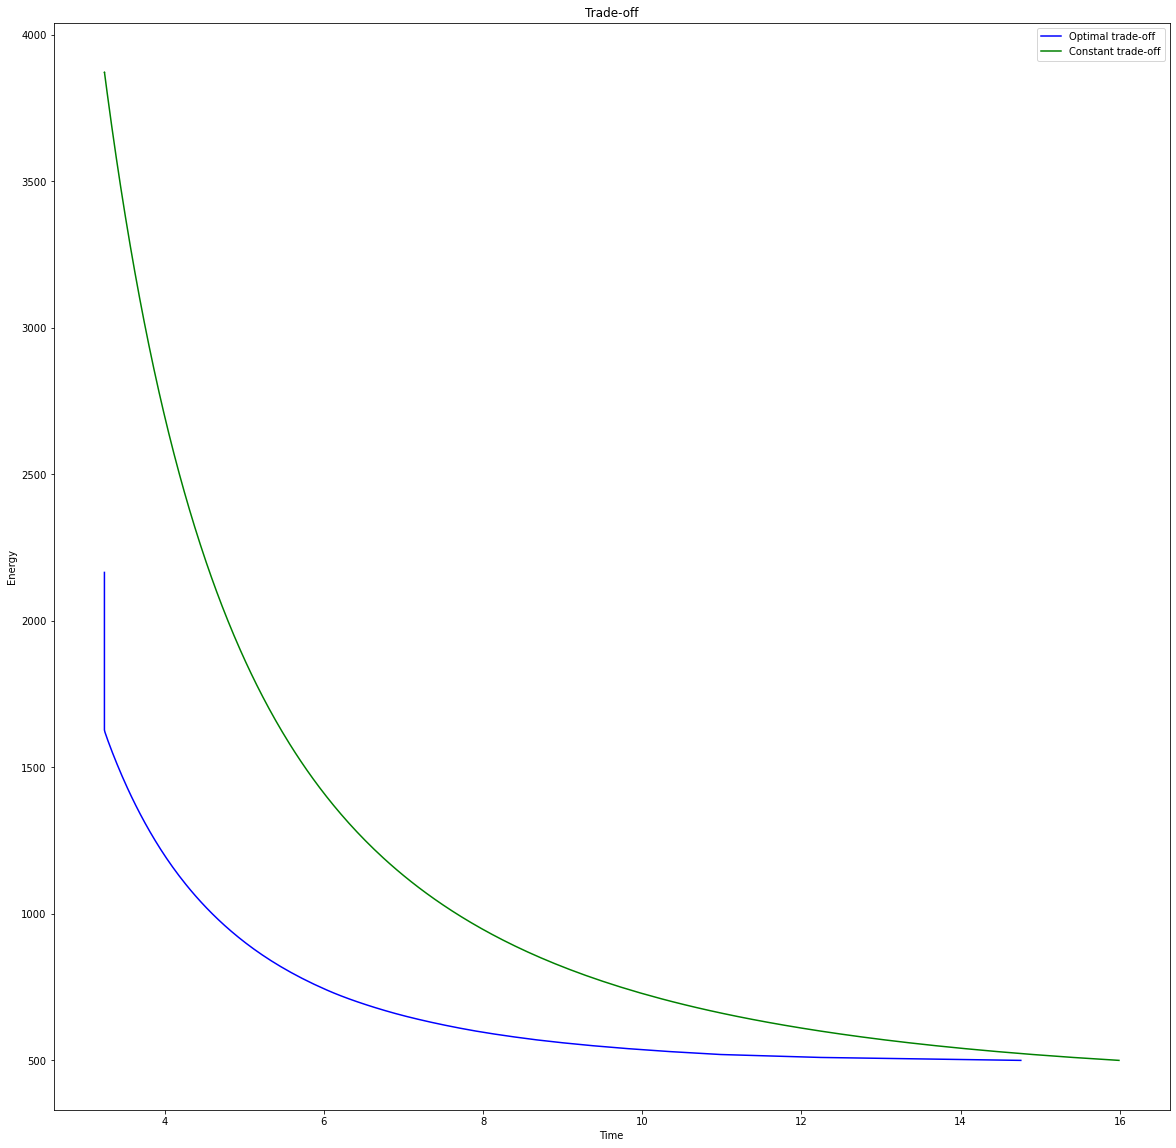

In [13]:
from proc_speed_data import *

alpha = np.array(alpha).reshape(n)
prec = np.array(prec) - 1 #чтобы нумерация начиналась с нуля

t_start = cp.Variable(n, pos=True)
t_finish = cp.Variable(n, pos=True)
tau = cp.Variable(n, pos=True)

E = tau + alpha + cp.multiply(alpha**2, cp.inv_pos(tau)) + cp.multiply(alpha**3, cp.inv_pos(tau)**2)
# С E солвер справляется только в таком виде

tau_cons = [alpha[i] / s_max <= tau[i] for i in range(n)] + [alpha[i] / s_min >= tau[i] for i in range(n)] 
t_cons = [t_finish[i] - t_start[i] == tau[i] for i in range(n)] + [t_finish[i[0]] <= t_start[i[1]] for i in prec]
const_cons = [tau[i] / alpha[i] == tau[i+1] / alpha[i+1] for i in range(n-1)] 

obj = cp.Minimize(cp.max(t_finish))

'''
Найдём значение энергии, при котором время перестаёт изменяться 
E_max = np.array([E for E in range(1000, 4000, 250)])
for E_maxi in E_max:
    problem = cp.Problem(obj, tau_cons + t_cons + [cp.sum(E) <= E_maxi])
    print(problem.solve(), E_maxi)
После 4-5 тысяч время перестаёт меняться
'''

t_opt = []
E_opt = []
t_const = []
E_const = []


for E_max in range(200, 5000, 10):
    problem_opt = cp.Problem(obj, tau_cons + t_cons + [cp.sum(E) <= E_max])
    res_opt = problem_opt.solve()
    if res_opt != np.inf and res_opt is not None:
        t_opt.append(res_opt)
        E_opt.append(np.sum(E.value))
    
    problem_const = cp.Problem(obj, tau_cons + t_cons + [cp.sum(E) <= E_max] + const_cons)
    res_const = problem_const.solve()
    if res_const != np.inf and res_const is not None:
        t_const.append(res_const)
        E_const.append(np.sum(E.value))

plt.figure(figsize=(20, 20))
plt.plot(t_opt, E_opt, label='Optimal trade-off', color='blue')
plt.plot(t_const, E_const, label='Constant trade-off', color='green')
plt.title('Trade-off')
plt.xlabel('Time')
plt.ylabel('Energy')
plt.legend()
plt.show()


Результаты соответствуют ожиданиям: время на зелёной кривой больше, чем на синей; при бОльших энергиях время становится меньше; при некотором достаточно большом значении энергии время становится постоянным (на синей кривой)

## 20.11 Optimal electric motor drive currents

Для максимизации эффективности двигателя нужно минимизировать потери мощности, так как "механический выход" фиксирован. Задача формулируется следующим образом:
$$ \frac{1}{N} \sum_i loss_i \rightarrow min  $$
$$ loss_i = I_i^T R I_i $$
$$ K_i^T I_i = \tau^{des} $$
$$ V_i = RI_i + \omega L \frac{I_{i+1} - I_i}{h} $$
Но при такой формулировке ограничение $ loss_i = I_i^T R I_i $ не будет являться выпуклым. Если мы заменим его на $ loss_i \geq I_i^T R I_i $, то оно станет выпуклым, при этом точное равенство будет достигнуто в точке оптимума.

In [3]:
#Данные для задачи (на гитхабе был файл только для matlab)
omega = 1000
V_supply = 640
tau_des = 100
N = 360
h = math.pi/180
R = np.diag([0.793, 0.793, 0.793])
L = np.diag([0.00386, 0.00386, 0.00386])
K = np.minimum(np.maximum(np.sin(np.linspace(-0.4, 2 * math.pi  + 0.4 , N + 49)),- 0.69), 0.69)
K = np.convolve(K, np.ones(50, dtype = float)/50, 'valid')
K = np.vstack([K, K[ [*range(N//3, N), *range(N//3)]], K[[*range(N//3 * 2 , N), *range(N//3 * 2)]] ])

Optimal power loss is 10979.868736492046
Optimal motor efficiency is 0.9010643203898323


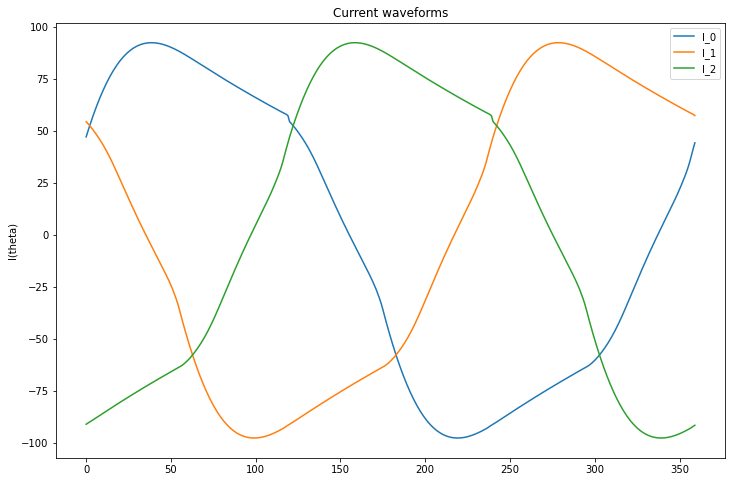

In [41]:
I = cp.Variable((3, N))
loss = cp.Variable(N)
    
# loss = [I[:, i].T @ R @ I[:, i] for i in range(N)]
"""
Если определить loss таким образом, то данное условие не будет являться выпуклым, поэтому 
зададим ограничение на loss нестрогим неравенством. Тогда ограничение станет выпуклым, и равенство будет выполняться 
в точке оптимума
"""


V = R @ I + omega/ h * L @ (I[:,[*range(1, N), 0]] - I) + omega  * K

I_cons = [K[:, i].T @ I[:, i] == tau_des for i in range(N)]
V_cons = [cp.abs(V) <= V_supply]
loss_cons = [loss[i] >= cp.quad_form(I[:, i], R) for i in range(N)]

obj = cp.sum(loss) / N
problem = cp.Problem(cp.Minimize(obj), I_cons + V_cons + loss_cons)
p_loss = problem.solve()
p_out = omega * tau_des
print(f'Optimal power loss is {p_loss}')
print(f'Optimal motor efficiency is {p_out / (p_out + p_loss)}')

cur = I.value
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(range(N), cur[i], label=f'I_{i}')
plt.title('Current waveforms')
plt.ylabel('I(theta)')
plt.legend()
plt.show()

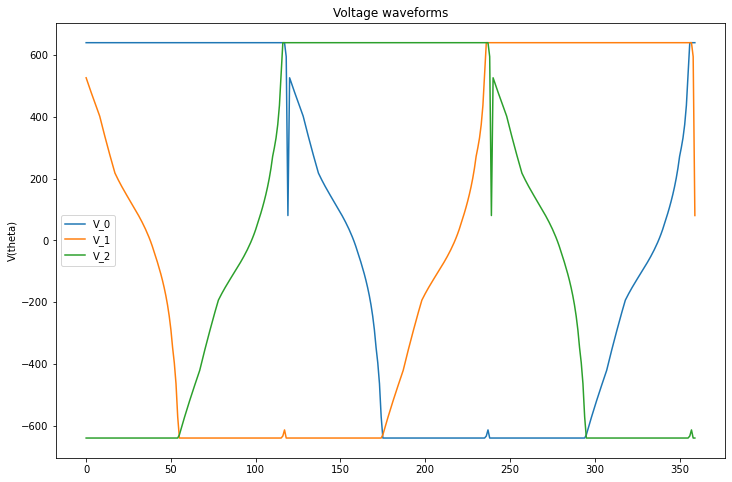

In [42]:
volt = V.value
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.plot(range(N), volt[i], label=f'V_{i}')
plt.title('Voltage waveforms')
plt.ylabel('V(theta)')
plt.legend()
plt.show()